# Dataset preparation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import transforms
import src.dataloading as data
from tqdm.auto import tqdm
from sklearn import svm, metrics
import matplotlib.pyplot as plt

# Load data

In [2]:
train_dataloader, valid_dataloader, test_dataloader = data.load_data()

# Model creation

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running model on:",device)

Running model on: cuda:0


In [4]:
model = torchvision.models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Freeze model weights

In [5]:
for param in model.parameters():
    param.requires_grad = False

## loss and optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Trainig

In [6]:
def train(n_epochs=5,validate=True):
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    for epoch in tqdm(range(n_epochs)):
        model.train()   
        running_loss = []
        correct = 0
        total = 0
        for data_t, targets_t in train_dataloader:
            data_t = data_t.to(device)
            targets_t = targets_t.to(device)
            optimizer.zero_grad()
            # Generate predictions
            out = model(data_t)
            # Calculate loss
            loss = criterion(out, targets_t)
            # append current batch loss
            running_loss.append(loss.item())
            #append current batch accuracy
            _, predicted = out.max(1)
            total += targets_t.size(0)
            correct += predicted.eq(targets_t).sum().item()
            # Backpropagation
            loss.backward()
            # Update model parameters
            optimizer.step()
        train_loss.append(np.average(running_loss))
        train_accuracy.append(correct/total)
        if validate:
            model.eval()
            running_loss = []
            correct = 0
            total = 0
            with torch.no_grad():
                for data_t, targets_t in valid_dataloader:
                    data_t = data_t.to(device)
                    targets_t = targets_t.to(device)
                    out = model(data_t)
                    loss = criterion(out, targets_t)
                    running_loss.append(loss.item())
                    _, predicted = out.max(1)
                    total += targets_t.size(0)
                    correct += predicted.eq(targets_t).sum().item()
                valid_loss.append(np.average(running_loss))
                valid_accuracy.append(correct/total) 
            #print("Loss: ",np.average(train_loss))
    return train_loss, train_accuracy, valid_loss, valid_accuracy

## TOP-K ACCURACY

In [7]:
def topk_accuracy(output: torch.Tensor, target: torch.Tensor, topk=(1,)) -> list([torch.FloatTensor]):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-5 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.

    ref:
    - https://pytorch.org/docs/stable/generated/torch.topk.html
    - https://discuss.pytorch.org/t/imagenet-example-accuracy-calculation/7840
    - https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b
    - https://discuss.pytorch.org/t/top-k-error-calculation/48815/2
    - https://stackoverflow.com/questions/59474987/how-to-get-top-k-accuracy-in-semantic-segmentation-using-pytorch

    :param output: output is the prediction of the model e.g. scores, logits, raw y_pred before normalization or getting classes
    :param target: target is the truth
    :param topk: tuple of topk's to compute e.g. (1, 2, 5) computes top 1, top 2 and top 5.
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, y_pred = output.topk(k=maxk, dim=1)
        y_pred = y_pred.t()
        target_reshaped = target.view(1, -1).expand_as(y_pred)
        correct = (y_pred == target_reshaped)

        list_topk_accs = []
        for k in topk:
            ind_which_topk_matched_truth = correct[:k]
            flattened_indicator_which_topk_matched_truth = ind_which_topk_matched_truth.reshape(-1).float()
            tot_correct_topk = flattened_indicator_which_topk_matched_truth.float().sum(dim=0, keepdim=True)
            topk_acc = tot_correct_topk / batch_size
            list_topk_accs.append(topk_acc.item())
        return list_topk_accs

## Validation

In [8]:
def test(dataloader=test_dataloader):
    val_loss = []
    val_acc = []
    top_1_2_5 = []
    batch_loss = 0
    correct_t = 0
    total_t = 0
    with torch.no_grad():
            model.eval()
            for data_t, target_t in (dataloader):
                data_t, target_t = data_t.to(device), target_t.to(device)
                out = model(data_t)
                loss = criterion(out, target_t)
                top_1_2_5.append(topk_accuracy(out,target_t,(1,2,5)))
                total_t += target_t.size(0)
                val_loss.append(loss.item())
            top_1_2_5 = np.mean(top_1_2_5,axis=0)
            print(f'Loss: {np.mean(val_loss):.4f}, TOP_1: {(top_1_2_5[0]):.3f}, TOP_2: {(top_1_2_5[1]):.3f}, TOP_5: {(top_1_2_5[2]):.3f}\n')

In [9]:
def plot_history():
    plt.plot(ta,'-o')
    plt.plot(va,'-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Validation Accuracy')
    plt.show()
    plt.plot(tl,'-o')
    plt.plot(vl,'-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Validation Loss')
    plt.show()


# Replace last fully connected layer

In [11]:
model.fc = nn.Linear(in_features=2048, out_features=120,bias=True)


# Update loss and optimizer for new model

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.to(device)
print()

In [13]:
tl,ta,vl,va = train(10)

100%|██████████| 10/10 [16:55<00:00, 101.59s/it]


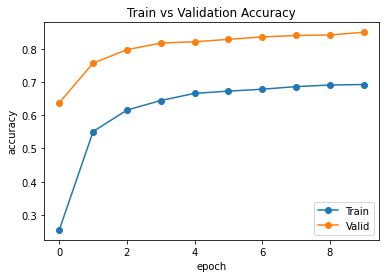

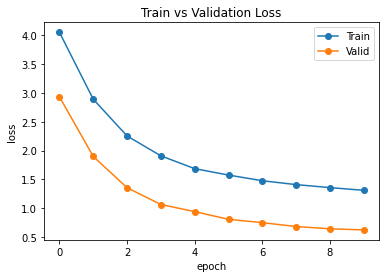

In [14]:
plot_history()

In [15]:
tl2,ta2,vl2,va2 = train(10)
torch.save(model.state_dict(), "models/m20_dict.pt")

100%|██████████| 10/10 [17:22<00:00, 104.21s/it]


In [16]:
tl.extend(tl2)
ta.extend(ta2)
vl.extend(vl2)
va.extend(va2)

In [17]:
test(test_dataloader)


Loss: 0.4805, TOP_1: 0.854, TOP_2: 0.941, TOP_5: 0.986



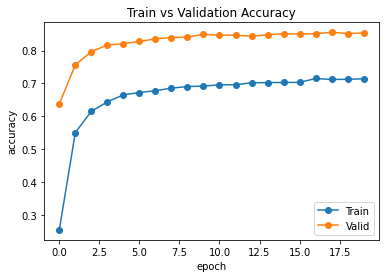

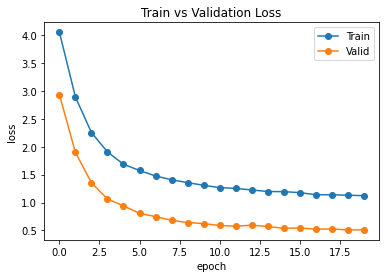

In [18]:
plot_history()

## Replace classifier layer with SVM

### Remove last fc layer from the model

In [19]:
model_no_fc = torch.nn.Sequential(*(list(model.children())[:-1]))
print(model_no_fc)
model_no_fc.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Prepare data

In [20]:
svm_data = []
svm_targets = []

for data_t, targets_t in tqdm(train_dataloader):
    data_t = data_t.to(device)
    out = model_no_fc(data_t)
    svm_data += [[j.item() for j in i] for i in out.cpu()]
    svm_targets += list(targets_t.numpy())

100%|██████████| 258/258 [02:14<00:00,  1.91it/s]


### Create, train and test SVMs with various kernels, with different misclassification allowance

In [21]:
def test_svm(_svm):
    loss = 0
    with torch.no_grad():
        model_no_fc.eval()
        for data_t, target_t in tqdm(valid_dataloader):
            data_t = data_t.to(device)
            out_no_fc = model_no_fc(data_t)
            out_no_fc = [[j.item() for j in i] for i in out_no_fc.cpu()]
            out = _svm.predict(out_no_fc)
            loss += metrics.hamming_loss(y_true=target_t.numpy(), y_pred=out)
        loss /= len(test_dataloader)
        print(f"Accuracy: {(100 * (1-loss)):.4f}%")

In [22]:
for kernel in "linear", "poly", "rbf":
    print("Kernel:", kernel)
    clf = svm.SVC(kernel=kernel, degree=2) # Degree works only for poly kernel.
    for C in 0.001, 0.01, 0.1, 1, 10, 100, 1000:
        print(f"\nC = {C}\n")
        clf.fit(svm_data, svm_targets)
        test_svm(clf)

Kernel: linear

C = 0.001

100%|██████████| 33/33 [00:39<00:00,  1.20s/it]
Accuracy: 81.4299%

C = 0.01

100%|██████████| 33/33 [00:38<00:00,  1.18s/it]
Accuracy: 81.1742%

C = 0.1

100%|██████████| 33/33 [00:39<00:00,  1.21s/it]
Accuracy: 81.4299%

C = 1

100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
Accuracy: 81.6856%

C = 10

100%|██████████| 33/33 [00:39<00:00,  1.20s/it]
Accuracy: 81.9413%

C = 100

100%|██████████| 33/33 [00:40<00:00,  1.22s/it]
Accuracy: 81.6856%

C = 1000

100%|██████████| 33/33 [00:39<00:00,  1.20s/it]
Accuracy: 81.6856%
Kernel: poly

C = 0.001

100%|██████████| 33/33 [00:40<00:00,  1.23s/it]
Accuracy: 82.9167%

C = 0.01

100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
Accuracy: 82.9167%

C = 0.1

100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
Accuracy: 83.1723%

C = 1

100%|██████████| 33/33 [00:38<00:00,  1.18s/it]
Accuracy: 82.6610%

C = 10

100%|██████████| 33/33 [00:38<00:00,  1.18s/it]
Accuracy: 83.1723%

C = 100

100%|██████████| 33/33 [00:39<00:00, 

# Unfreeeze last conv block

In [24]:

for param in model.layer4[2].parameters():
    param.requires_grad = True

In [25]:
tl2,ta2,vl2,va2 = train(10)
test(test_dataloader)

100%|██████████| 10/10 [17:22<00:00, 104.20s/it]
Loss: 0.4787, TOP_1: 0.848, TOP_2: 0.938, TOP_5: 0.983



In [27]:
tl.extend(tl2)
ta.extend(ta2)
vl.extend(vl2)
va.extend(va2)

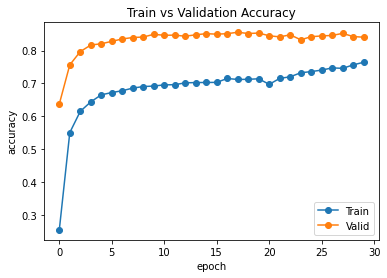

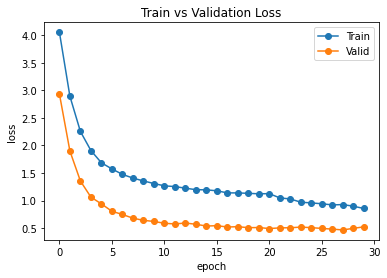

In [28]:
plot_history()

In [26]:
torch.save(model.state_dict(), "models/m30_dict.pt")

# Unfreeeze second-to-last conv block

In [29]:
for param in model.layer4[1].parameters():
    param.requires_grad = True

In [30]:
tl2,ta2,vl2,va2 = train(10)
test(test_dataloader)

100%|██████████| 10/10 [17:13<00:00, 103.36s/it]
Loss: 0.5354, TOP_1: 0.837, TOP_2: 0.930, TOP_5: 0.980



In [31]:
tl.extend(tl2)
ta.extend(ta2)
vl.extend(vl2)
va.extend(va2)

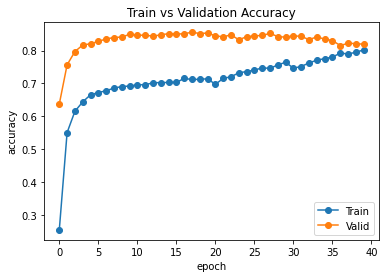

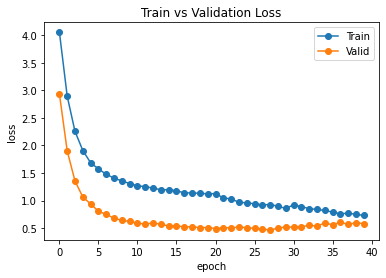

In [32]:
plot_history()

In [33]:
torch.save(model.state_dict(), "models/m40_dict.pt")

# Untrained model

In [34]:
model = torchvision.models.resnet50(pretrained=False)
model.fc = nn.Linear(in_features=2048, out_features=120,bias=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model.to(device)
print()

In [35]:
tl,ta,vl,va = train(30)
test(test_dataloader)

100%|██████████| 30/30 [1:47:43<00:00, 215.45s/it]
Loss: 2.4701, TOP_1: 0.358, TOP_2: 0.505, TOP_5: 0.699



In [37]:
torch.save(model.state_dict(), "models/fresh_30_dict.pt")

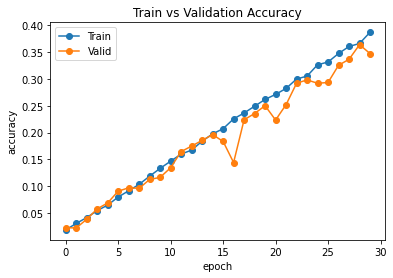

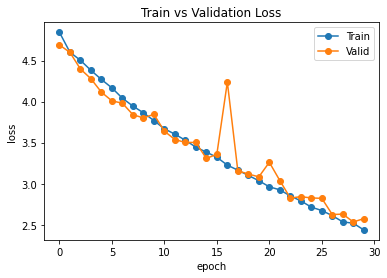

In [36]:
plot_history()

# Simplified model

In [4]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [5]:
model = torchvision.models.resnet50(pretrained=False)
model.fc = nn.Linear(in_features=1024, out_features=120,bias=True)
model.layer4 = Identity()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
tl,ta,vl,va = train(30)
test(test_dataloader)

100%|██████████| 30/30 [1:28:31<00:00, 177.05s/it]
Loss: 2.3780, TOP_1: 0.375, TOP_2: 0.519, TOP_5: 0.708



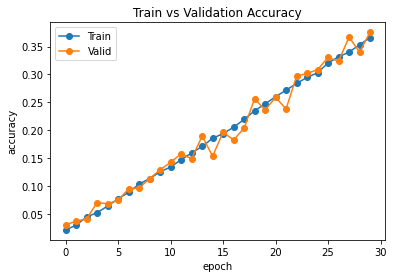

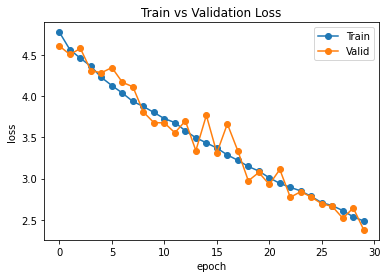

In [11]:
torch.save(model.state_dict(), "models/simple_fresh_30_dict.pt")
plot_history()